In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from ipyleaflet import Map, Marker, AntPath

# Load the NMEA data
nmea_data = pd.read_csv('/content/drive/MyDrive/nmea.csv')

# Display the first few rows to check the structure
print(nmea_data.head())

# Clean column names to remove leading/trailing spaces
nmea_data.columns = nmea_data.columns.str.strip()

# Extract coordinates and plot
latitudes = nmea_data['lat']
longitudes = nmea_data['lon']
coordinates = list(zip(latitudes, longitudes))

# Initialize the map centered at the experiment area
from ipyleaflet import Map, Marker, AntPath
experiment_center = (latitudes.mean(), longitudes.mean())  # Centering on the average position
m = Map(center=experiment_center, zoom=10)

# Add the path
ant_path = AntPath(locations=coordinates, delay=1000, color='blue', pulse_color='red')
m.add_layer(ant_path)

# Add a marker at the experiment center
marker = Marker(location=experiment_center, draggable=False)
m.add_layer(marker)

# Display the map
m



Map(center=[69.22800419146513, 15.889516057467993], controls=(ZoomControl(options=['position', 'zoom_in_text',…

           timestamp        lat        lon   height
0  2024-09-10T090057  69.212358  15.858596      4.2
1  2024-09-10T090058  69.212358  15.858596      4.3
2  2024-09-10T090059  69.212360  15.858596      4.4
3  2024-09-10T090100  69.212360  15.858595      4.5
4  2024-09-10T090101  69.212361  15.858596      4.7


In [ ]:
print("Missing values in each column:")
print(nmea_data.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(nmea_data.duplicated().sum())

# Display the data types of each column
print("\nData types in the dataset:")
print(nmea_data.dtypes)

# Check for anomalies in latitude and longitude ranges
print("\nLatitude range: ", nmea_data['lat'].min(), "-", nmea_data['lat'].max())
print("Longitude range: ", nmea_data['lon'].min(), "-", nmea_data['lon'].max())

Missing values in each column:
timestamp    0
lat          0
lon          0
height       0
dtype: int64

Number of duplicate rows:
0

Data types in the dataset:
timestamp     object
lat          float64
lon          float64
height       float64
dtype: object

Latitude range:  69.136349 - 69.297479
Longitude range:  15.676663 - 15.995005


In [3]:
import pandas as pd

# Load the AGC data
agc_data = pd.read_csv('/content/drive/MyDrive/agc.csv')

# Clean column names
agc_data.columns = agc_data.columns.str.strip()

# Drop columns with 100% missing values
agc_data_cleaned = agc_data.dropna(axis=1, how='all')

# Select relevant columns for jamming detection
relevant_columns = ['DriftNanosPerSecond', 'DriftUncertaintyNanosPerSecond']
agc_data_cleaned = agc_data_cleaned[relevant_columns]

# Convert relevant columns to numeric
for col in relevant_columns:
    agc_data_cleaned[col] = pd.to_numeric(agc_data_cleaned[col], errors='coerce')

# Handle missing values
for col in relevant_columns:
    agc_data_cleaned[col].fillna(agc_data_cleaned[col].median(), inplace=True)

# Save the cleaned data
agc_data_cleaned.to_csv('agc_cleaned.csv', index=False)

print("Cleaned AGC data:")
print(agc_data_cleaned.info())


<ipython-input-3-19c6929f8fb6>:4: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  agc_data = pd.read_csv('/content/drive/MyDrive/agc.csv')
<ipython-input-3-19c6929f8fb6>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  agc_data_cleaned[col].fillna(agc_data_cleaned[col].median(), inplace=True)


Cleaned AGC data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84273 entries, 0 to 84272
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   DriftNanosPerSecond             84273 non-null  float64
 1   DriftUncertaintyNanosPerSecond  84273 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB
None


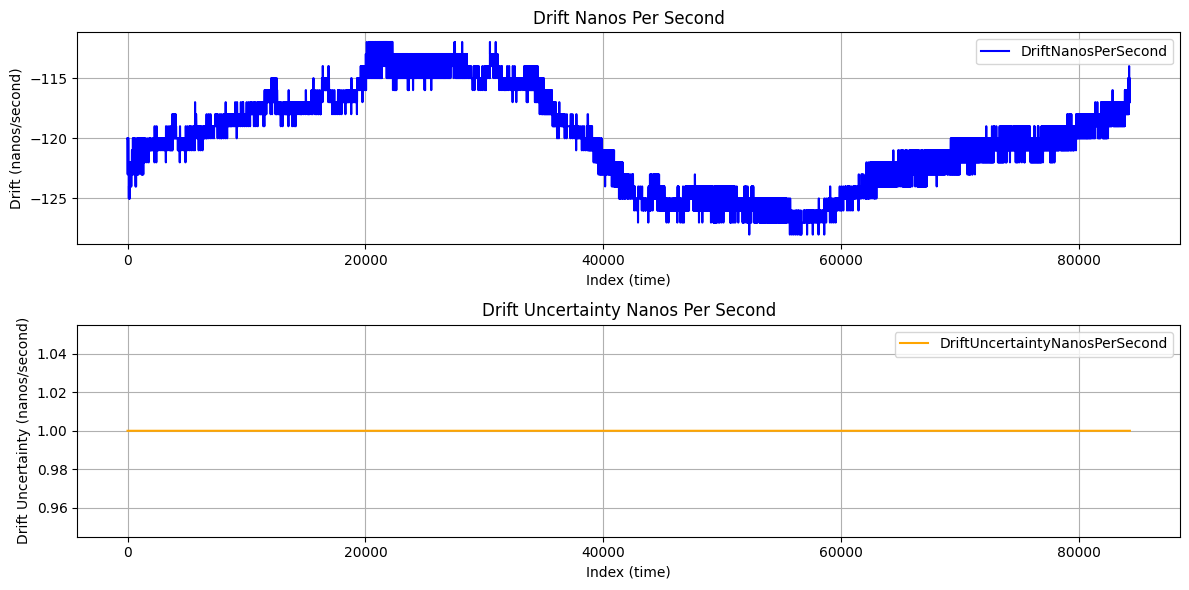

In [4]:
import matplotlib.pyplot as plt

# Plot trends for DriftNanosPerSecond and DriftUncertaintyNanosPerSecond
plt.figure(figsize=(12, 6))

# Plot DriftNanosPerSecond
plt.subplot(2, 1, 1)
plt.plot(agc_data_cleaned['DriftNanosPerSecond'], label='DriftNanosPerSecond', color='blue')
plt.title('Drift Nanos Per Second')
plt.xlabel('Index (time)')
plt.ylabel('Drift (nanos/second)')
plt.grid()
plt.legend()

# Plot DriftUncertaintyNanosPerSecond
plt.subplot(2, 1, 2)
plt.plot(agc_data_cleaned['DriftUncertaintyNanosPerSecond'], label='DriftUncertaintyNanosPerSecond', color='orange')
plt.title('Drift Uncertainty Nanos Per Second')
plt.xlabel('Index (time)')
plt.ylabel('Drift Uncertainty (nanos/second)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
# Calculate rate of change (difference between successive values)
agc_data_cleaned['Drift_RateOfChange'] = agc_data_cleaned['DriftNanosPerSecond'].diff()
agc_data_cleaned['Uncertainty_RateOfChange'] = agc_data_cleaned['DriftUncertaintyNanosPerSecond'].diff()

# Calculate rolling averages (window size: 10)
agc_data_cleaned['Drift_RollingMean'] = agc_data_cleaned['DriftNanosPerSecond'].rolling(window=10).mean()
agc_data_cleaned['Uncertainty_RollingMean'] = agc_data_cleaned['DriftUncertaintyNanosPerSecond'].rolling(window=10).mean()

# Calculate Z-scores for anomaly detection
agc_data_cleaned['Drift_ZScore'] = (agc_data_cleaned['DriftNanosPerSecond'] - agc_data_cleaned['DriftNanosPerSecond'].mean()) / agc_data_cleaned['DriftNanosPerSecond'].std()
agc_data_cleaned['Uncertainty_ZScore'] = (agc_data_cleaned['DriftUncertaintyNanosPerSecond'] - agc_data_cleaned['DriftUncertaintyNanosPerSecond'].mean()) / agc_data_cleaned['DriftUncertaintyNanosPerSecond'].std()

# Preview engineered features
print(agc_data_cleaned.head())


   DriftNanosPerSecond  DriftUncertaintyNanosPerSecond  Drift_RateOfChange  \
0               -120.0                             1.0                 NaN   
1               -120.0                             1.0                 0.0   
2               -120.0                             1.0                 0.0   
3               -120.0                             1.0                 0.0   
4               -120.0                             1.0                 0.0   

   Uncertainty_RateOfChange  Drift_RollingMean  Uncertainty_RollingMean  \
0                       NaN                NaN                      NaN   
1                       0.0                NaN                      NaN   
2                       0.0                NaN                      NaN   
3                       0.0                NaN                      NaN   
4                       0.0                NaN                      NaN   

   Drift_ZScore  Uncertainty_ZScore  
0     -0.006434                 NaN  
1   

In [6]:
# Forward-fill or drop rows with incomplete rolling mean calculations
agc_data_cleaned['Drift_RollingMean'] = agc_data_cleaned['Drift_RollingMean'].fillna(agc_data_cleaned['DriftNanosPerSecond'])
agc_data_cleaned['Uncertainty_RollingMean'] = agc_data_cleaned['Uncertainty_RollingMean'].fillna(agc_data_cleaned['DriftUncertaintyNanosPerSecond'])

# Replace NaN Z-scores with 0
agc_data_cleaned['Drift_ZScore'] = agc_data_cleaned['Drift_ZScore'].fillna(0)
agc_data_cleaned['Uncertainty_ZScore'] = agc_data_cleaned['Uncertainty_ZScore'].fillna(0)


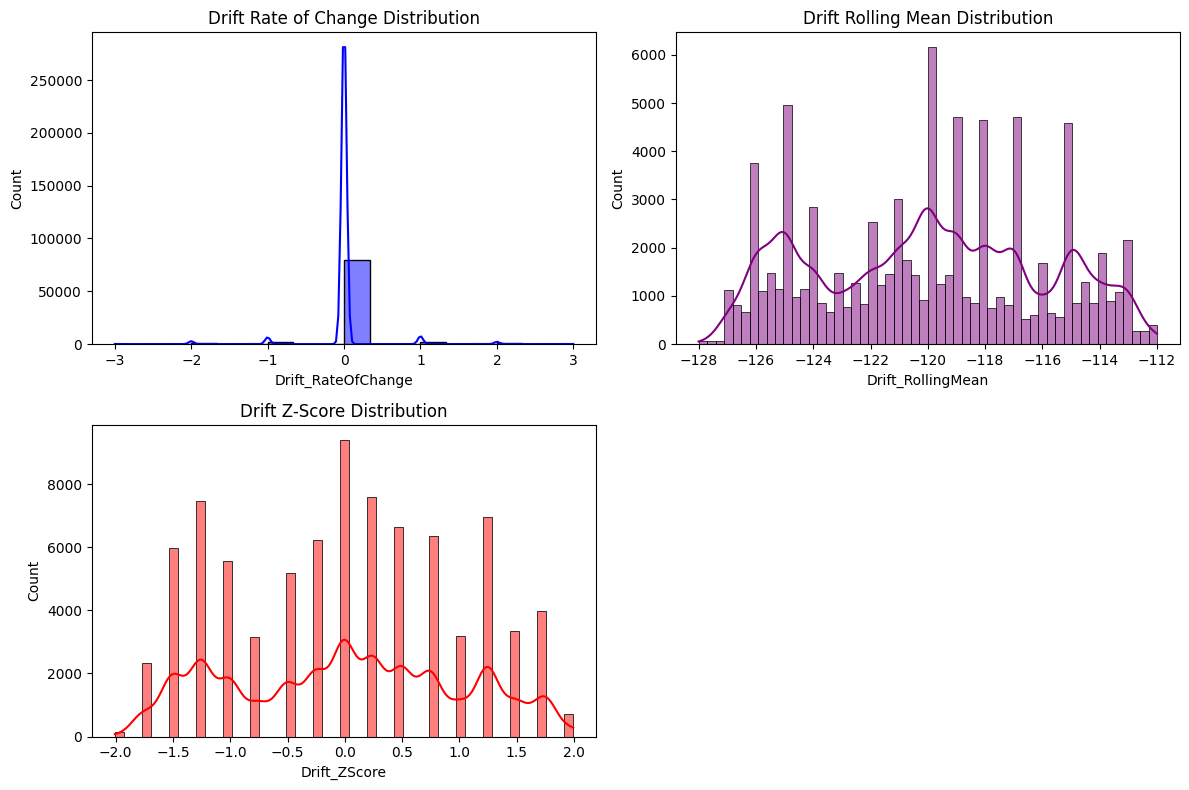

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histograms for new features
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(agc_data_cleaned['Drift_RateOfChange'], kde=True, color='blue')
plt.title('Drift Rate of Change Distribution')

plt.subplot(2, 2, 2)
sns.histplot(agc_data_cleaned['Drift_RollingMean'], kde=True, color='purple')
plt.title('Drift Rolling Mean Distribution')

plt.subplot(2, 2, 3)
sns.histplot(agc_data_cleaned['Drift_ZScore'], kde=True, color='red')
plt.title('Drift Z-Score Distribution')


plt.tight_layout()
plt.show()


In [8]:
import pandas as pd

# Load the odometer files (update the file paths as needed)
file1 = pd.read_csv('/content/drive/MyDrive/odometer_2024-09-10T1407.log', sep='\t', header=None)
file2 = pd.read_csv('/content/drive/MyDrive/odometer_2024-09-10T1429.log', sep='\t', header=None)

# Concatenate the files into a single DataFrame
odometer_data = pd.concat([file1, file2], ignore_index=True)

# Step 1: Extract and clean the Timestamp and Speed columns

# Extract timestamp from the first column by splitting the text at the first comma
odometer_data['Timestamp'] = odometer_data[0].str.split(',', expand=True)[0]

# Extract the correct speed field (third segment after splitting by comma)
odometer_data['Speed'] = odometer_data[0].str.split(',', expand=True)[2].str.strip()

# Remove irrelevant text like "kilometer_per_hour" and convert to numeric
odometer_data['Speed'] = odometer_data['Speed'].str.extract('([0-9.]+)').astype(float)

# Step 2: Convert the cleaned Timestamp to datetime format
odometer_data['Timestamp'] = pd.to_datetime(odometer_data['Timestamp'], unit='s', errors='coerce')

# Drop rows with invalid timestamps or speeds
odometer_data = odometer_data.dropna(subset=['Timestamp', 'Speed'])

# Preview the cleaned data
print("\nCleaned Odometer Data:")
print(odometer_data.head())



Cleaned Odometer Data:
                                                   0  \
1  1725970102.516497 , 30878.6 , 0.0 kilometer_pe...   
2  1725970102.699386 , 30878.6 , 0.0 kilometer_pe...   
3  1725970102.847159 , 30878.6 , 0.0 kilometer_pe...   
4  1725970102.99026 , 30878.6 , 0.0 kilometer_per...   
5  1725970103.136788 , 30878.6 , 0.0 kilometer_pe...   

                      Timestamp  Speed  
1 2024-09-10 12:08:22.516496897    0.0  
2 2024-09-10 12:08:22.699385881    0.0  
3 2024-09-10 12:08:22.847158909    0.0  
4 2024-09-10 12:08:22.990259886    0.0  
5 2024-09-10 12:08:23.136787891    0.0  


<ipython-input-8-653f65cfc32a>:22: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  odometer_data['Timestamp'] = pd.to_datetime(odometer_data['Timestamp'], unit='s', errors='coerce')


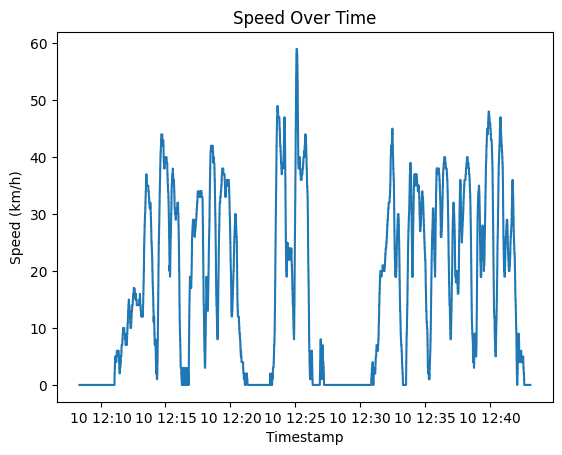

In [ ]:
import matplotlib.pyplot as plt

plt.plot(odometer_data['Timestamp'], odometer_data['Speed'])
plt.xlabel('Timestamp')
plt.ylabel('Speed (km/h)')
plt.title('Speed Over Time')
plt.show()


In [9]:
import pandas as pd


# Preview the column
print("\nPreview of `utcTimeMillis` Column:")
print(agc_data['utcTimeMillis'].head())

# Convert to numeric directly, handling invalid rows
agc_data['utcTimeMillis'] = pd.to_numeric(agc_data['utcTimeMillis'], errors='coerce')

# Drop rows with invalid utcTimeMillis
invalid_rows = agc_data[agc_data['utcTimeMillis'].isna()]
print(f"Number of invalid rows removed: {len(invalid_rows)}")
agc_data = agc_data.dropna(subset=['utcTimeMillis']).copy()

# Convert to datetime
agc_data['Timestamp'] = pd.to_datetime(agc_data['utcTimeMillis'], unit='ms')

# Preview the cleaned and converted data
print("\nCleaned AGC Data with Timestamps:")
print(agc_data[['utcTimeMillis', 'Timestamp']].head())




Preview of `utcTimeMillis` Column:
0    utcTimeMillis
1    1725958857000
2    1725958857000
3    1725958857000
4    1725958857000
Name: utcTimeMillis, dtype: object
Number of invalid rows removed: 1

Cleaned AGC Data with Timestamps:
   utcTimeMillis           Timestamp
1   1.725959e+12 2024-09-10 09:00:57
2   1.725959e+12 2024-09-10 09:00:57
3   1.725959e+12 2024-09-10 09:00:57
4   1.725959e+12 2024-09-10 09:00:57
5   1.725959e+12 2024-09-10 09:00:57


In [10]:
# Shift odometer timestamps earlier by 3 hours
odometer_data['Timestamp'] = odometer_data['Timestamp'] - pd.Timedelta(hours=3)

# Check the new timestamp range
print("Adjusted Odometer Timestamp Range:", odometer_data['Timestamp'].min(), odometer_data['Timestamp'].max())


Adjusted Odometer Timestamp Range: 2024-09-10 09:08:22.516496897 2024-09-10 09:43:05.841784


Resample and Interpolate odometer_data
Resample the odometer_data at 1-second intervals and fill gaps using interpolation.

In [11]:
# Ensure odometer_data_interpolated is defined before extending the range
odometer_data_interpolated = (
    odometer_data
    .set_index('Timestamp')  # Set Timestamp as the index
    .sort_index()
    .interpolate(method='time')
    .reset_index()
)

# Extend odometer timestamps to match the full AGC range
full_range = pd.date_range(
    start=agc_data['Timestamp'].min(),
    end=agc_data['Timestamp'].max(),
    freq='1s'
)

# Reindex odometer data to match the full range
odometer_data_extended = (
    odometer_data_interpolated
    .set_index('Timestamp')
    .reindex(full_range)
    .infer_objects()
    .interpolate()
    .reset_index()
)

# Rename the new index back to Timestamp
odometer_data_extended.rename(columns={'index': 'Timestamp'}, inplace=True)

# Check the new extended range
print("Corrected Extended Odometer Timestamp Range:",
      odometer_data_extended['Timestamp'].min(),
      odometer_data_extended['Timestamp'].max())


Corrected Extended Odometer Timestamp Range: 2024-09-10 09:00:57 2024-09-10 11:56:40


<ipython-input-11-a1c0bb111ee0>:3: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  odometer_data


In [12]:
# Perform an exact merge to match rows with the same Timestamp
merged_data = pd.merge(
    agc_data,
    odometer_data_extended,
    on='Timestamp',
    how='inner'
)

# Check the number of matched rows
print(f"Number of rows matched with direct merge: {len(merged_data)}")

# Preview the merged dataset
print("\nExact Merged Data Preview:")
print(merged_data.head())


Number of rows matched with direct merge: 49440

Exact Merged Data Preview:
  # Raw  utcTimeMillis    TimeNanos LeapSecond TimeUncertaintyNanos  \
0   Agc   1.725959e+12  14118000000        NaN                  NaN   
1   Agc   1.725959e+12  14118000000        NaN                  NaN   
2   Agc   1.725959e+12  14118000000        NaN                  NaN   
3   Agc   1.725959e+12  14118000000        NaN                  NaN   
4   Agc   1.725959e+12  14118000000        NaN                  NaN   

          FullBiasNanos BiasNanos BiasUncertaintyNanos DriftNanosPerSecond  \
0  -1409994060882236537       0.0     5.16689718106489                 NaN   
1  -1409994060882236537       0.0     5.16689718106489                 NaN   
2  -1409994060882236537       0.0     5.16689718106489                 NaN   
3  -1409994060882236537       0.0     5.16689718106489                 NaN   
4  -1409994060882236537       0.0     5.16689718106489                 NaN   

  DriftUncertaintyNanosPerSe

In [13]:
# Replace NaN Speed values with 0.0
merged_data['Speed'] = merged_data['Speed'].fillna(0.0)

# Preview the updated merged dataset
print("\nUpdated Merged Data Preview with Speed Values:")
print(merged_data.head())



Updated Merged Data Preview with Speed Values:
  # Raw  utcTimeMillis    TimeNanos LeapSecond TimeUncertaintyNanos  \
0   Agc   1.725959e+12  14118000000        NaN                  NaN   
1   Agc   1.725959e+12  14118000000        NaN                  NaN   
2   Agc   1.725959e+12  14118000000        NaN                  NaN   
3   Agc   1.725959e+12  14118000000        NaN                  NaN   
4   Agc   1.725959e+12  14118000000        NaN                  NaN   

          FullBiasNanos BiasNanos BiasUncertaintyNanos DriftNanosPerSecond  \
0  -1409994060882236537       0.0     5.16689718106489                 NaN   
1  -1409994060882236537       0.0     5.16689718106489                 NaN   
2  -1409994060882236537       0.0     5.16689718106489                 NaN   
3  -1409994060882236537       0.0     5.16689718106489                 NaN   
4  -1409994060882236537       0.0     5.16689718106489                 NaN   

  DriftUncertaintyNanosPerSecond  ... BasebandCn0DbHz  \

In [ ]:
# Save the merged dataset to a CSV file
merged_data.to_csv('merged_data.csv', index=False)


In [14]:

# Convert 'DriftNanosPerSecond' to numeric and handle missing values
merged_data['DriftNanosPerSecond'] = pd.to_numeric(merged_data['DriftNanosPerSecond'], errors='coerce')
merged_data['DriftNanosPerSecond'] = merged_data['DriftNanosPerSecond'].fillna(merged_data['DriftNanosPerSecond'].median())

# Derive features for analysis
merged_data['Speed_Deviation'] = abs(merged_data['Speed'] - merged_data['Speed'].mean())  # Deviation from mean speed
merged_data['Speed_RollingMean'] = merged_data['Speed'].rolling(window=10).mean()  # Rolling mean for speed
merged_data['Drift_RollingMean'] = merged_data['DriftNanosPerSecond'].rolling(window=10).mean()  # Rolling mean for drift
merged_data['Speed_RateOfChange'] = merged_data['Speed'].diff()  # Rate of change for speed
merged_data['Drift_RateOfChange'] = merged_data['DriftNanosPerSecond'].diff()  # Rate of change for drift

# Display the first few rows of the engineered dataset
feature_columns = ['Speed', 'Speed_Deviation', 'Speed_RollingMean',
                   'Speed_RateOfChange', 'Drift_RollingMean',
                   'Drift_RateOfChange']
print("\nPreview of Feature-Engineered Data:")
print(merged_data[feature_columns].head())





Preview of Feature-Engineered Data:
   Speed  Speed_Deviation  Speed_RollingMean  Speed_RateOfChange  \
0    0.0              0.0                NaN                 NaN   
1    0.0              0.0                NaN                 0.0   
2    0.0              0.0                NaN                 0.0   
3    0.0              0.0                NaN                 0.0   
4    0.0              0.0                NaN                 0.0   

   Drift_RollingMean  Drift_RateOfChange  
0                NaN                 NaN  
1                NaN                 0.0  
2                NaN                 0.0  
3                NaN                 0.0  
4                NaN                 0.0  


Drop speed-based feature computations since Speed is constant

In [15]:
# Drop speed-based feature computations since Speed is constant
print("Skipping Speed-based features: Speed is constant.")

# Validate Drift-based features
print("DriftNanosPerSecond Summary:")
print(merged_data['DriftNanosPerSecond'].describe())
print("\nNon-NaN Drift Values:")
print(merged_data[merged_data['DriftNanosPerSecond'].notna()].head())


Skipping Speed-based features: Speed is constant.
DriftNanosPerSecond Summary:
count    49440.000000
mean      -121.139644
std          3.076050
min       -128.000000
25%       -124.000000
50%       -121.000000
75%       -119.000000
max       -114.000000
Name: DriftNanosPerSecond, dtype: float64

Non-NaN Drift Values:
  # Raw  utcTimeMillis    TimeNanos LeapSecond TimeUncertaintyNanos  \
0   Agc   1.725959e+12  14118000000        NaN                  NaN   
1   Agc   1.725959e+12  14118000000        NaN                  NaN   
2   Agc   1.725959e+12  14118000000        NaN                  NaN   
3   Agc   1.725959e+12  14118000000        NaN                  NaN   
4   Agc   1.725959e+12  14118000000        NaN                  NaN   

          FullBiasNanos BiasNanos BiasUncertaintyNanos  DriftNanosPerSecond  \
0  -1409994060882236537       0.0     5.16689718106489               -121.0   
1  -1409994060882236537       0.0     5.16689718106489               -121.0   
2  -140999406088

In [16]:
# Drop speed-related features
merged_data = merged_data.drop(columns=['Speed_Deviation', 'Speed_RollingMean', 'Speed_RateOfChange'], errors='ignore')

# Retain and preview drift-related features
feature_columns = ['DriftNanosPerSecond', 'Drift_RollingMean', 'Drift_RateOfChange']
print("\nPreview of Drift Features:")
print(merged_data[feature_columns].head(15))  # Show more rows to visualize rolling features



Preview of Drift Features:
    DriftNanosPerSecond  Drift_RollingMean  Drift_RateOfChange
0                -121.0                NaN                 NaN
1                -121.0                NaN                 0.0
2                -121.0                NaN                 0.0
3                -121.0                NaN                 0.0
4                -121.0                NaN                 0.0
5                -121.0                NaN                 0.0
6                -121.0                NaN                 0.0
7                -121.0                NaN                 0.0
8                -123.0                NaN                -2.0
9                -123.0             -121.4                 0.0
10               -123.0             -121.6                 0.0
11               -123.0             -121.8                 0.0
12               -123.0             -122.0                 0.0
13               -123.0             -122.2                 0.0
14               -123.0    

In [17]:
# Handle NaN values in rolling mean and rate of change features
merged_data['Drift_RollingMean'] = merged_data['Drift_RollingMean'].fillna(merged_data['DriftNanosPerSecond'].mean())
merged_data['Drift_RateOfChange'] = merged_data['Drift_RateOfChange'].fillna(0)  # Replace NaN with 0 for initial rows

# Display refined feature-engineered dataset
print("\nRefined Feature-Engineered Data:")
print(merged_data[feature_columns].head())



Refined Feature-Engineered Data:
   DriftNanosPerSecond  Drift_RollingMean  Drift_RateOfChange
0               -121.0        -121.139644                 0.0
1               -121.0        -121.139644                 0.0
2               -121.0        -121.139644                 0.0
3               -121.0        -121.139644                 0.0
4               -121.0        -121.139644                 0.0


Label  data
The refactored method ensures consistency by prioritizing "jammed" over "normal" intervals, which avoids conflicts caused by overlapping intervals in the dataset.
It provides scalability and efficiency, using structured interval prioritization and vectorized operations, making it more suitable for large datasets.
The high-quality labels generated by the refactored method improve data reliability, which is crucial for training accurate and robust classification models.

In [18]:
import pandas as pd

# Paths to plan files
plan_files = [
    r"/content/drive/MyDrive/plan-monday-2024-09-09.json",
    r"/content/drive/MyDrive/plan-friday-2024-09-13.json",
    r"/content/drive/MyDrive/plan-wednesday-2024-09-11.json",
    r"/content/drive/MyDrive/plan-thursday-2024-09-12.json",
    r"/content/drive/MyDrive/plan-tuesday-2024-09-10.json"
]

# Load and combine plan files
plan_data_list = [pd.read_json(file) for file in plan_files]
combined_plan_data = pd.concat(plan_data_list, ignore_index=True)

# Extract intervals for "jammed" and "normal"
jammed_intervals = pd.DataFrame([
    (pd.to_datetime(test['start_time']), pd.to_datetime(test['end_time']), 'jammed')
    for location in combined_plan_data['locations']
    for test in location['tests']
    if test['power_w'] > 0
], columns=['start', 'end', 'Label'])

normal_intervals = pd.DataFrame([
    (pd.to_datetime(test['start_time']), pd.to_datetime(test['end_time']), 'normal')
    for location in combined_plan_data['locations']
    for test in location['tests']
    if test['power_w'] == 0
], columns=['start', 'end', 'Label'])

# Combine intervals with priorities
jammed_intervals['Priority'] = 1  # Higher priority for jammed
normal_intervals['Priority'] = 2  # Lower priority for normal
all_intervals = pd.concat([jammed_intervals, normal_intervals]).sort_values(by=['start', 'Priority'])

# Initialize default label
merged_data['Label'] = 'unknown'

# Apply labels based on combined intervals
for _, row in all_intervals.iterrows():
    mask = (merged_data['Timestamp'] >= row['start']) & (merged_data['Timestamp'] <= row['end'])
    merged_data.loc[mask, 'Label'] = row['Label']

# Display final label distribution
print("\nFinal Label Distribution:")
print(merged_data['Label'].value_counts())

# Preview labeled data
print("\nSample of Labeled Data:")
print(merged_data[['Timestamp', 'Label']].head())

# Debug: Check overlap for normal intervals
overlap_with_normal = []
for _, row in normal_intervals.iterrows():
    overlap = merged_data[(merged_data['Timestamp'] >= row['start']) &
                          (merged_data['Timestamp'] <= row['end'])]
    overlap_with_normal.append(len(overlap))

print(f"\nNumber of timestamps overlapping with normal intervals: {sum(overlap_with_normal)}")

# Validate rows labeled as normal
print("\nSample of Rows Labeled as Normal:")
print(merged_data[merged_data['Label'] == 'normal'].head())



Final Label Distribution:
Label
jammed     39384
unknown     5256
normal      4800
Name: count, dtype: int64

Sample of Labeled Data:
            Timestamp   Label
0 2024-09-10 09:00:57  jammed
1 2024-09-10 09:00:57  jammed
2 2024-09-10 09:00:57  jammed
3 2024-09-10 09:00:57  jammed
4 2024-09-10 09:00:57  jammed

Number of timestamps overlapping with normal intervals: 9608

Sample of Rows Labeled as Normal:
      # Raw  utcTimeMillis      TimeNanos LeapSecond TimeUncertaintyNanos  \
20128   Agc   1.725966e+12  6677117000000        NaN                  NaN   
20129   Agc   1.725966e+12  6677117000000        NaN                  NaN   
20130   Agc   1.725966e+12  6677117000000        NaN                  NaN   
20131   Agc   1.725966e+12  6677117000000        NaN                  NaN   
20132   Agc   1.725966e+12  6677117000000        NaN                  NaN   

              FullBiasNanos BiasNanos BiasUncertaintyNanos  \
20128  -1409994060883043116       0.0             1.899304   
2

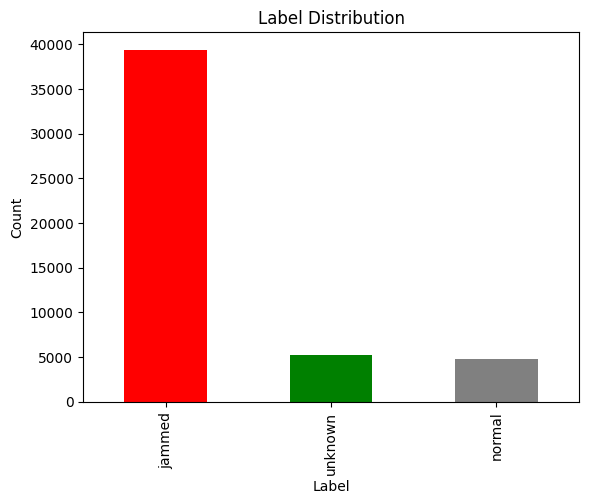

In [ ]:
import matplotlib.pyplot as plt

# Plot label distribution
label_counts = merged_data['Label'].value_counts()
label_counts.plot(kind='bar', color=['red', 'green', 'gray'])
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [ ]:
merged_data.to_csv("merged_data_refactored.csv", index=False)


In [19]:
# Select features for training
features = ['Drift_RollingMean', 'Drift_RateOfChange']  # Focus on drift-based features
X = merged_data[features]
y = merged_data['Label']  # 'jammed', 'normal', or 'unknown'

# Remove rows with 'unknown' labels, as they cannot be used for binary classification
valid_data = merged_data[merged_data['Label'].isin(['jammed', 'normal'])]

# Update features (X) and labels (y) with valid data
X = valid_data[features]
y = valid_data['Label']

# Convert labels to binary format (0 = normal, 1 = jammed)
y_binary = y.map({'normal': 0, 'jammed': 1})

# Verify the prepared data
print("Selected Features (X) Preview:")
print(X.head())

print("\nBinary Labels (y_binary) Distribution:")
print(y_binary.value_counts())


Selected Features (X) Preview:
   Drift_RollingMean  Drift_RateOfChange
0        -121.139644                 0.0
1        -121.139644                 0.0
2        -121.139644                 0.0
3        -121.139644                 0.0
4        -121.139644                 0.0

Binary Labels (y_binary) Distribution:
Label
1    39384
0     4800
Name: count, dtype: int64


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.25, random_state=0)

print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")


Training set size: 33138, Testing set size: 11046


Apply LogisticRegression


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1159
           1       0.90      1.00      0.94      9887

    accuracy                           0.90     11046
   macro avg       0.45      0.50      0.47     11046
weighted avg       0.80      0.90      0.85     11046



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


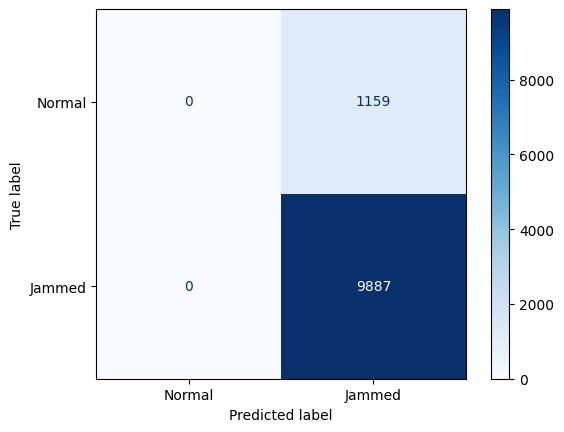

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Jammed"]).plot(cmap="Blues")


Apply XGB Classifier

In [22]:
from xgboost import XGBClassifier

# Train XGBoost with scale_pos_weight
imbalance_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_model = XGBClassifier(eval_metric='logloss', use_label_encoder=False, scale_pos_weight=imbalance_ratio)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:51:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.97      0.49      1159
           1       1.00      0.77      0.87      9887

    accuracy                           0.79     11046
   macro avg       0.66      0.87      0.68     11046
weighted avg       0.93      0.79      0.83     11046



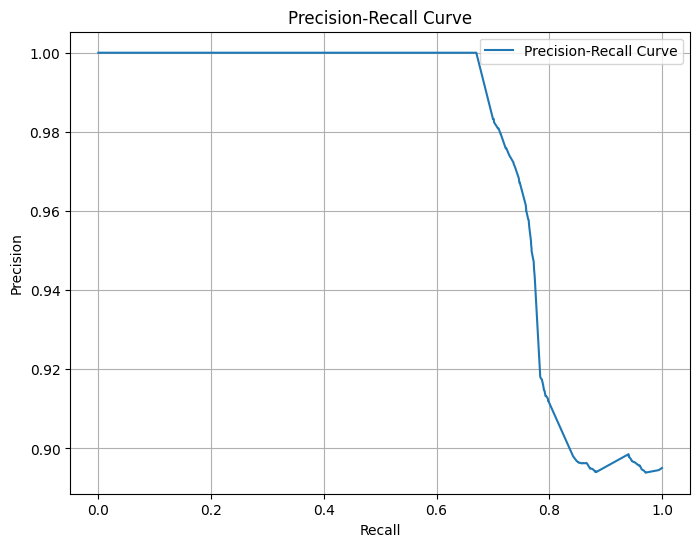

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()


 Gradient Boosting Optimization
using Bayesian Optimization (via Optuna) to fine-tune the hyperparameters of a Gradient Boosting model like XGBoost. This model builds an ensemble of decision trees, where each tree tries to correct the errors of the previous ones.

Key Steps:
Hyperparameters Tuned:
max_depth: Controls the complexity of each tree.
learning_rate: Determines how much each tree contributes to the overall model.
n_estimators: Number of trees in the ensemble.
scale_pos_weight: Balances the model for imbalanced datasets (e.g., "jammed" vs. "normal").
The optimization objective is the F1-score, which balances precision and recall.
Equations Involved:
Logarithmic Loss (Objective Function):

LogLoss
=
−
1
𝑁
∑
𝑖
=
1
𝑁
[
𝑦
𝑖
log
⁡
(
𝑝
𝑖
)
+
(
1
−
𝑦
𝑖
)
log
⁡
(
1
−
𝑝
𝑖
)
]
LogLoss=−
N
1
​
  
i=1
∑
N
​
 [y
i
​
 log(p
i
​
 )+(1−y
i
​
 )log(1−p
i
​
 )]
Where:

𝑦
𝑖
y
i
​
  is the true label (0 or 1).
𝑝
𝑖
p
i
​
  is the predicted probability for the positive class.
𝑁
N is the number of samples.
F1-Score (Optimization Target):

𝐹
1
=
2
⋅
Precision
⋅
Recall
Precision
+
Recall
F1=2⋅
Precision+Recall
Precision⋅Recall
​

Where:

Precision =
True Positives
True Positives + False Positives
True Positives + False Positives
True Positives
​

Recall =
True Positives
True Positives + False Negatives
True Positives + False Negatives
True Positives
​



In [24]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [25]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameter search space
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 20),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10, log=True),
    }

    # Train XGBoost model with parameters
    model = XGBClassifier(**param, eval_metric='logloss')
    model.fit(X_train, y_train)

    # Make predictions
    X_test_cleaned = X_test[features]
    y_pred = model.predict(X_test_cleaned)

    # Return F1-score for evaluation
    return f1_score(y_test, y_pred, average='macro')


features = ['Drift_RollingMean', 'Drift_RateOfChange']  # Feature columns used for training

# Start the study with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Best hyperparameters found
print("\nBest Hyperparameters Found:")
print(study.best_params)

# Train a final model with the best hyperparameters
best_model = XGBClassifier(**study.best_params, eval_metric='logloss')
best_model.fit(X_train, y_train)

# Make predictions with the optimized model
X_test_cleaned = X_test[features]
y_pred_xgb = best_model.predict(X_test_cleaned)

# Evaluate the final model
print("\nXGBoost Classification Report (Optimized Model):")
print(classification_report(y_test, y_pred_xgb))


[I 2024-11-25 12:53:17,966] A new study created in memory with name: no-name-11ae3c60-5551-4f56-ba30-852485d9a33e
[I 2024-11-25 12:53:18,185] Trial 0 finished with value: 0.4723164381598433 and parameters: {'max_depth': 5, 'learning_rate': 0.11425258874284926, 'n_estimators': 147, 'scale_pos_weight': 5, 'colsample_bytree': 0.8565596563858346, 'subsample': 0.6385891226950322, 'reg_alpha': 0.0023407568931439315, 'reg_lambda': 0.1809889651908028}. Best is trial 0 with value: 0.4723164381598433.
[I 2024-11-25 12:53:19,016] Trial 1 finished with value: 0.4749658931953327 and parameters: {'max_depth': 5, 'learning_rate': 0.12098140015078246, 'n_estimators': 332, 'scale_pos_weight': 15, 'colsample_bytree': 0.9362937680574233, 'subsample': 0.5119603931942551, 'reg_alpha': 1.6797254198863125, 'reg_lambda': 0.022746913341123713}. Best is trial 1 with value: 0.4749658931953327.
[I 2024-11-25 12:53:19,439] Trial 2 finished with value: 0.4723164381598433 and parameters: {'max_depth': 7, 'learning_r


Best Hyperparameters Found:
{'max_depth': 6, 'learning_rate': 0.02149573290393232, 'n_estimators': 426, 'scale_pos_weight': 1, 'colsample_bytree': 0.9007870935490261, 'subsample': 0.9563385940542506, 'reg_alpha': 0.4820377386078364, 'reg_lambda': 1.278250595276817}

XGBoost Classification Report (Optimized Model):
              precision    recall  f1-score   support

           0       0.64      0.27      0.38      1159
           1       0.92      0.98      0.95      9887

    accuracy                           0.91     11046
   macro avg       0.78      0.62      0.66     11046
weighted avg       0.89      0.91      0.89     11046



<ipython-input-50-2c3c2380e935>:7: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


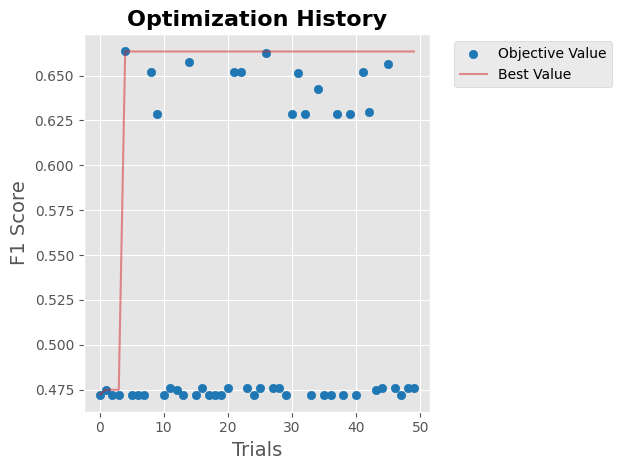

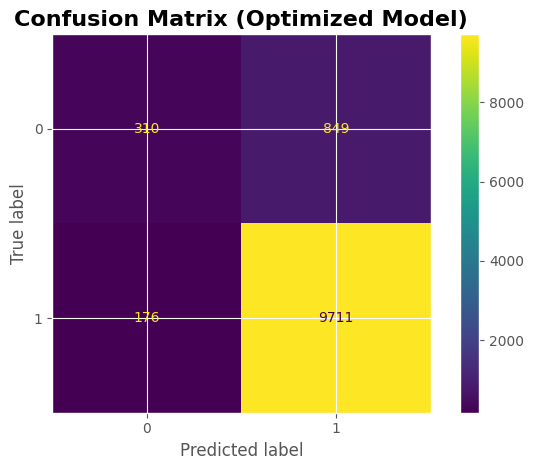

In [50]:
import matplotlib.pyplot as plt
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# --- 1. Plot Optimization History ---
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History", fontsize=16, weight="bold")
plt.xlabel("Trials", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)
plt.tight_layout()
plt.show()


# Confusion Matrix for Final Model ---
# Generate a confusion matrix for the optimized model's predictions
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='viridis', values_format='d', colorbar=True)
plt.title("Confusion Matrix (Optimized Model)", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()



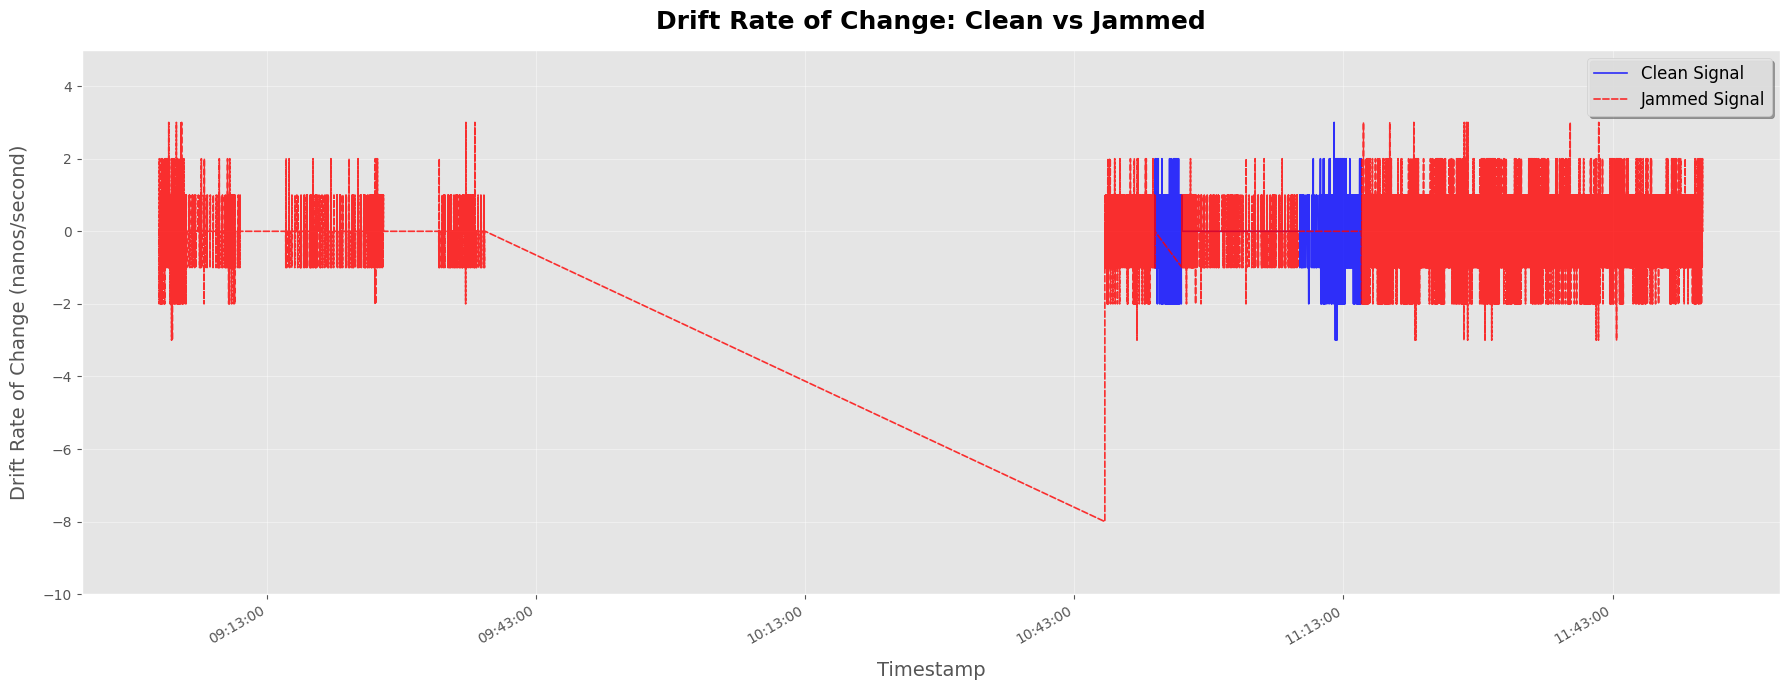

In [54]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Separate clean and jammed signals
clean_signal = merged_data[merged_data['Label'] == 'normal']
jammed_signal = merged_data[merged_data['Label'] == 'jammed']

# --- Optimized Visualization: Clean vs Jammed Signals ---
plt.figure(figsize=(18, 7))
# Format x-axis for timestamps
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
plt.gcf().autofmt_xdate()

# Plot clean signal
plt.plot(
    clean_signal['Timestamp'],
    clean_signal['Drift_RateOfChange'],
    label='Clean Signal',
    color='blue',
    alpha=0.8,
    linewidth=1.2
)

# Plot jammed signal with clearer dashes and line separation
plt.plot(
    jammed_signal['Timestamp'],
    jammed_signal['Drift_RateOfChange'],
    label='Jammed Signal',
    color='red',
    alpha=0.8,
    linewidth=1.2,
    linestyle='--',  # Maintain dashed lines for jammed signals
    dash_capstyle='round'
)

# Add labels, title, and legend
plt.title('Drift Rate of Change: Clean vs Jammed', fontsize=18, weight='bold', pad=15)
plt.xlabel('Timestamp', fontsize=14, labelpad=10)
plt.ylabel('Drift Rate of Change (nanos/second)', fontsize=14, labelpad=10)
plt.legend(fontsize=12, loc='upper right', frameon=True, framealpha=0.9, shadow=True)
plt.grid(alpha=0.4)

#
plt.ylim(-10, 5)

# Adjust layout for clarity
plt.tight_layout()
plt.show()


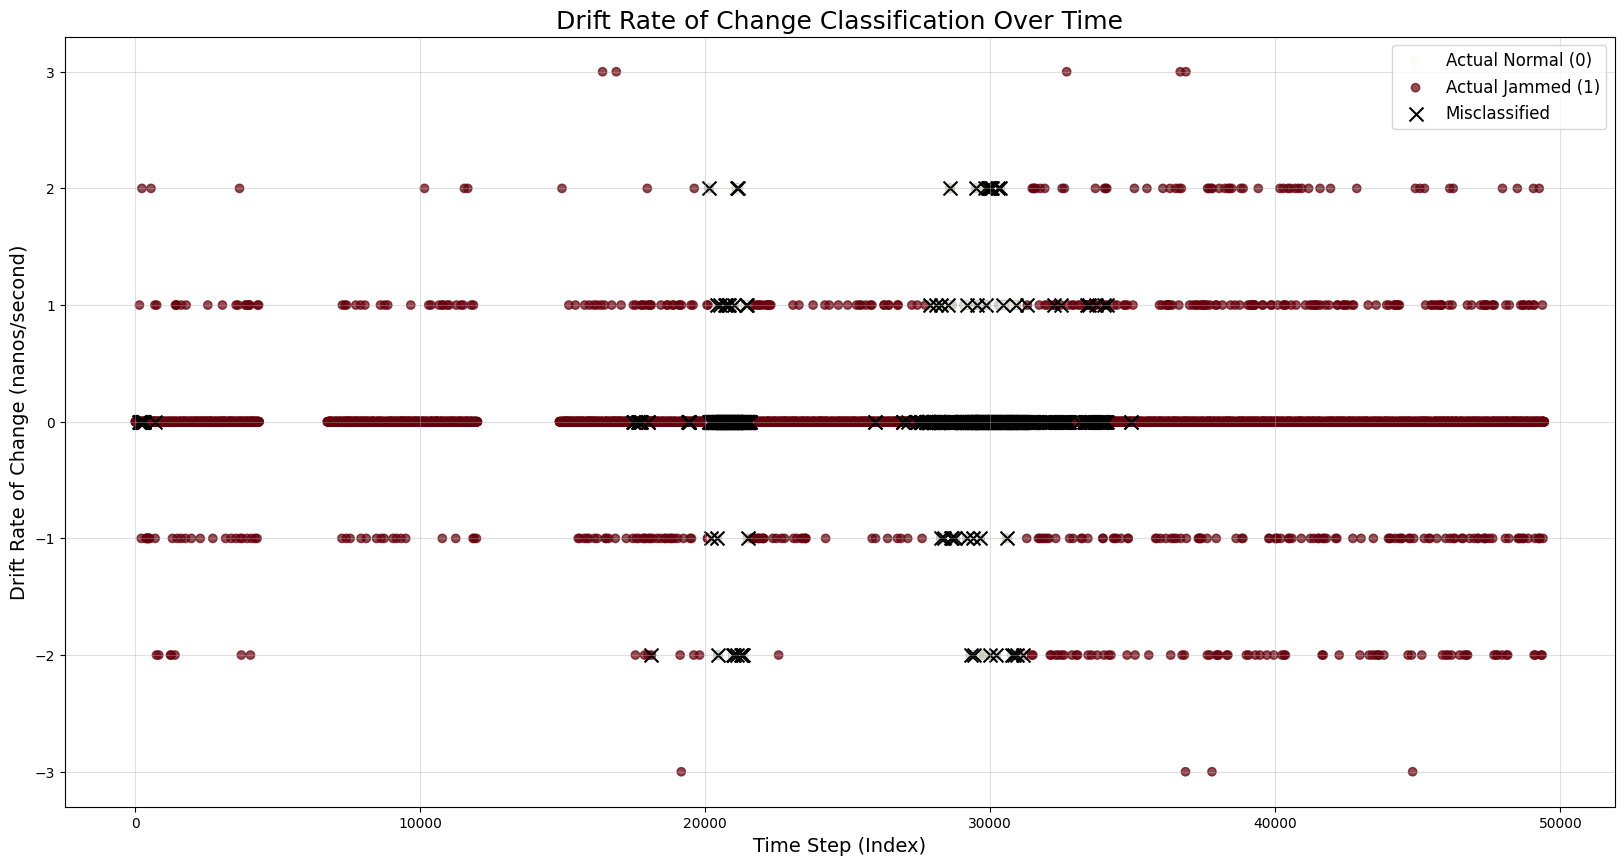

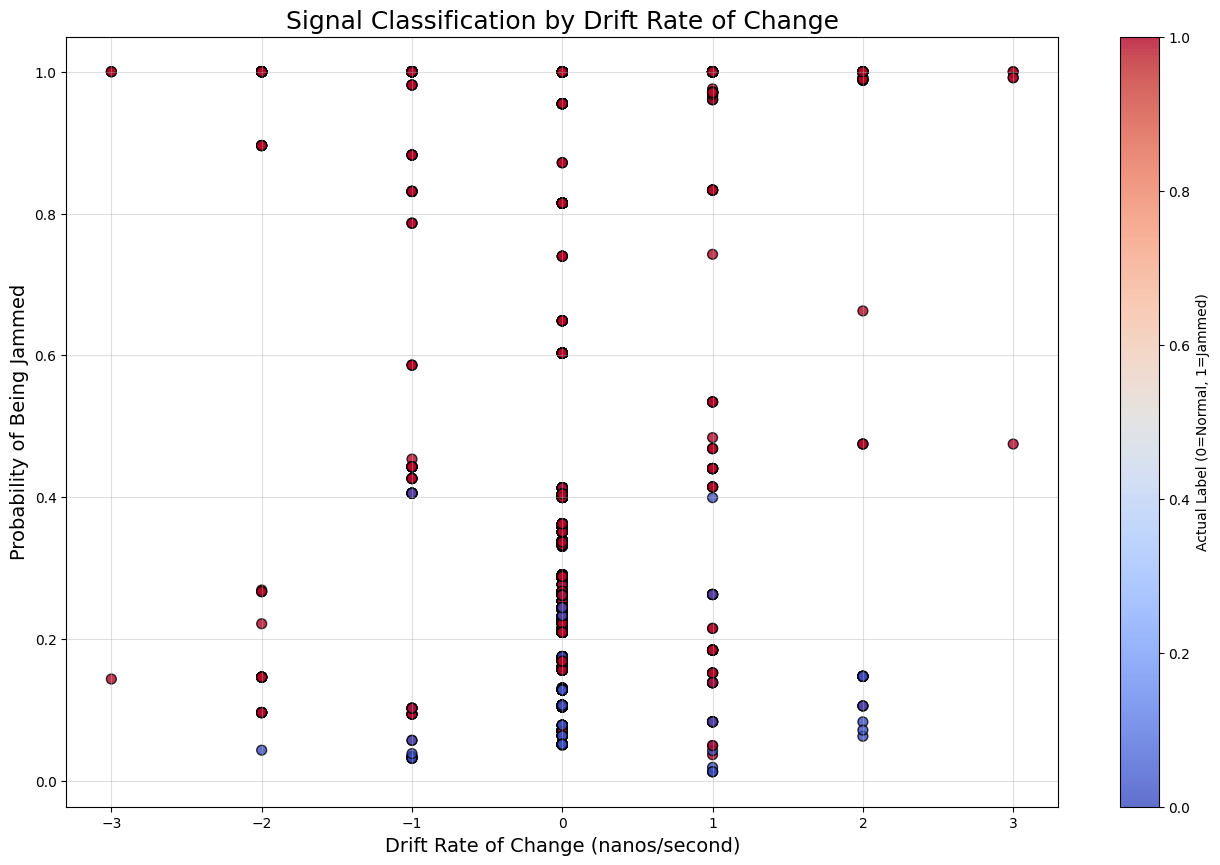

In [31]:
# Add Actual labels to X_test
X_test = X_test.copy()
X_test['Actual'] = y_test.values

# Add Predictions to X_test
X_test['Prediction'] = y_pred_xgb

# Add Probabilities (if available)
y_prob = xgb_model.predict_proba(X_test[features])[:, 1]
X_test['Probability'] = y_prob

# --- Visualization 1: Signal Behavior Over Time ---
plt.figure(figsize=(20, 10))

# Plot Drift_RateOfChange for Normal Signals
plt.scatter(
    X_test.index,
    X_test['Drift_RateOfChange'],
    c=(X_test['Actual'] == 0).astype(int),
    cmap='Greens',
    label='Actual Normal (0)',
    alpha=0.7
)

# Plot Drift_RateOfChange for Jammed Signals
plt.scatter(
    X_test.index,
    X_test['Drift_RateOfChange'],
    c=(X_test['Actual'] == 1).astype(int),
    cmap='Reds',
    label='Actual Jammed (1)',
    alpha=0.7
)

# Highlight Misclassifications
misclassified = X_test[X_test['Actual'] != X_test['Prediction']]
plt.scatter(
    misclassified.index,
    misclassified['Drift_RateOfChange'],
    c='black',
    label='Misclassified',
    marker='x',
    s=100
)

# Titles and Labels
plt.title('Drift Rate of Change Classification Over Time', fontsize=18)
plt.xlabel('Time Step (Index)', fontsize=14)
plt.ylabel('Drift Rate of Change (nanos/second)', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(alpha=0.4)
plt.show()

# --- Visualization 2: Signal Distribution in Drift_RateOfChange ---
plt.figure(figsize=(16, 10))

# Plot all signals, coloring by Actual Labels
plt.scatter(
    X_test['Drift_RateOfChange'],
    X_test['Probability'],
    c=X_test['Actual'],
    cmap='coolwarm',
    alpha=0.8,
    s=50,
    edgecolor='k',
    label='Signal Points'
)

# Titles and Labels
plt.title('Signal Classification by Drift Rate of Change', fontsize=18)
plt.xlabel('Drift Rate of Change (nanos/second)', fontsize=14)
plt.ylabel('Probability of Being Jammed', fontsize=14)
plt.grid(alpha=0.4)
plt.colorbar(label="Actual Label (0=Normal, 1=Jammed)")
plt.show()


Comparison of Logistic Regression and XGBoost Classifier for GNSS Jamming Detection
1- Logistic Regression (LR)
Logistic Regression (LR) is a linear model primarily designed for binary classification tasks.
In our application, it is used to distinguish between normal and jammed signals based on features such as Drift_RollingMean and Drift_RateOfChange.
Key Observations
Strengths:
 Logistic Regression is computationally efficient and interpretable, making it suitable for applications where real-time detection is critical.
Baseline Performance: It provides a reliable benchmark for evaluating the performance of more complex models.
Scalability: Scales well with large datasets.
Limitations:
Linear Assumption: LR assumes a linear relationship between features and the target, which may not fully capture the complexities of GNSS signal behaviors under jamming.
Performance on Imbalanced Data: Logistic Regression struggles with imbalanced datasets unless combined with techniques like class weighting.
future work
Extension to Multinomial Logistic Regression (MLR):
Logistic Regression can be extended to Multinomial Logistic Regression (MLR) to classify signals into multiple categories (e.g., normal, jammed, and spoofed). This makes it highly adaptable for future work involving GNSS spoofing detection.
https://machinelearningmastery.com/multinomial-logistic-regression-with-python/

2- XGBoost Classifier (XGB)
Model Summary
XGBoost is a tree-based ensemble model that builds multiple decision trees and combines them to achieve high accuracy.
It uses gradient boosting to iteratively reduce prediction errors, making it highly effective for complex and imbalanced datasets.
Strengths:
Non-Linear Modeling: XGBoost captures non-linear relationships between features, making it well-suited for complex GNSS signal behaviors.
Handles Imbalanced Data: The scale_pos_weight parameter addresses class imbalance, improving performance on the minority class (jammed signals).
High Performance: Delivers superior accuracy, precision, and recall compared to Logistic Regression.
Limitations:
Computational Cost: XGBoost requires more time and resources to train due to its complexity.
